#Starting with Data

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.8 MB/s 
     |████████████████████████████████| 9.8 MB 41.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time 
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


**Importing File**

In [4]:
dfs = pd.read_csv("/content/ICICIBANK.NS (2).csv")

dfs.shape()

In [5]:
dfs.head(5)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-28,677.900024,687.000000,670.049988,685.049988,683.049988,18367497
1,2021-07-29,692.500000,692.500000,683.099976,687.500000,687.500000,11043138
2,2021-07-30,687.000000,687.650024,678.000000,682.500000,682.500000,14536250
3,2021-08-02,684.049988,688.049988,677.700012,681.400024,681.400024,9348206
4,2021-08-03,683.000000,691.900024,676.650024,690.400024,690.400024,10162609


**Now Make sure that the datatype of dataset 
aligns with the compatibility of ARIMA model.**

1:Make 'Date' Attribute in dataset of DateTime format
(Date dataset may be of String format)

Check date type as follows

In [6]:
type(dfs.Date[0])

str

If the date format is in **string** we need to convert it into **dateTime** format as follows

In [7]:
dfs['Date'] = pd.to_datetime(dfs['Date'], format='%Y-%m-%d')

Now again check **Date** type

In [8]:
type(dfs.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

Above is the correct data type

**Split Data** 

In [9]:
n = int(len(dfs)*0.8)
df = dfs[:n]
test_data = dfs[n:]
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%Y-%m-%d')
test_data = test_data.groupby('Date')[['Close']].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#Exploratory Data Analysis



1:Detect and Remove Null Values

2:Group only the relevant attributes from the dataset, that is, ‘Date’ and ‘Close’. **Using "groupby() function"**


In [10]:
#check number of null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
#looking null cells
df[df.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [12]:
#dropping null cells
df1=df.dropna()
df1.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-28,677.900024,687.000000,670.049988,685.049988,683.049988,18367497
1,2021-07-29,692.500000,692.500000,683.099976,687.500000,687.500000,11043138
2,2021-07-30,687.000000,687.650024,678.000000,682.500000,682.500000,14536250
3,2021-08-02,684.049988,688.049988,677.700012,681.400024,681.400024,9348206
4,2021-08-03,683.000000,691.900024,676.650024,690.400024,690.400024,10162609


In [13]:
#groupby()
df2 = df1.groupby('Date')[['Close']].mean()
df2.head(5)

,Close
Date,
2021-07-28,685.049988
2021-07-29,687.500000
2021-07-30,682.500000
2021-08-02,681.400024
2021-08-03,690.400024


#Stationarity Test and Finding p,q and d manually

A data is said to be stationary if the mean variance and autocorrelation structure do not show any difference over time.

**Augmented Dickey Fuller Test**

In [14]:
#Check if price series is stationary
result = adfuller(df2.Close)
print(f"ADF Statistics: {result[0]}")
print(f"p-value       : {result[1]}")

ADF Statistics: -2.3640338046970597
p-value       : 0.15214590748192192


***p-value greter than 0.05 suggest that series is not stationary***

**Autocorretional Function (ACF)**

i.e. To find Order of Differentiating  **"d"**

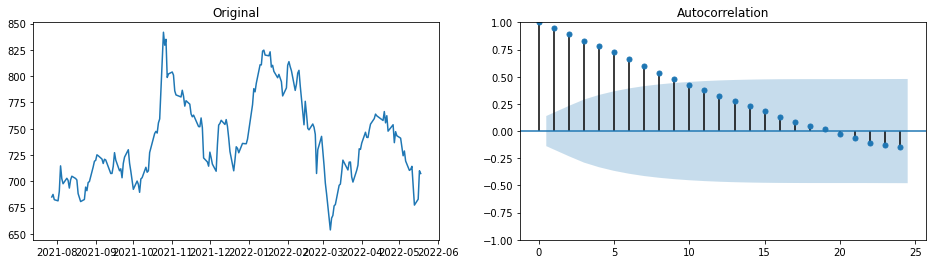

In [15]:
#original graph of data and acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df2.Close)
ax1.set_title('Original')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(df2.Close, ax = ax2);

Clearly From graph also we can see that graph is not stationary

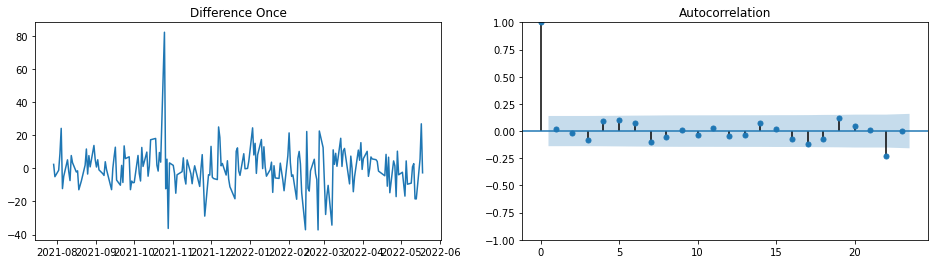

In [16]:
#Differenced Once
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

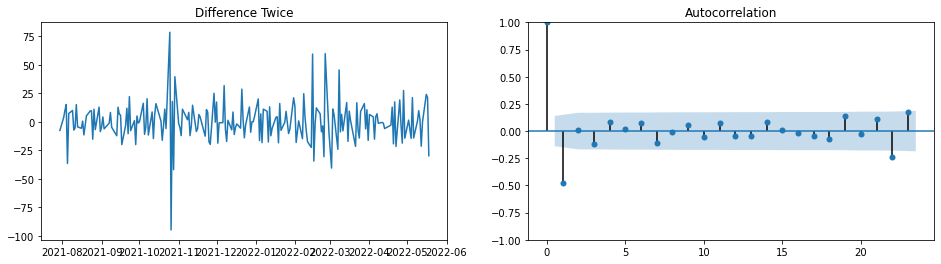

In [17]:
#Differenced Twice
diff = df2.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Twice')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

d=1 may be good choice
Lets also check d vlue using pmdarima package 

In [18]:
from pmdarima.arima.utils import ndiffs


In [19]:
ndiffs(df2.Close,test="adf")

1

Cross check above with d value that we got earlier

**Next part is to find "auto regressiver" term i.e. "p" term**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


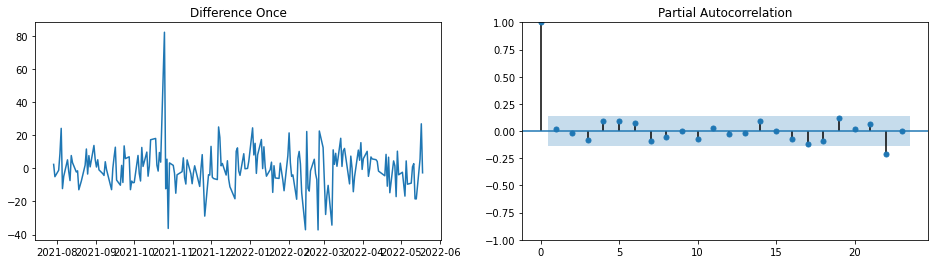

In [20]:
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
#add ; to end of the plot function so that the plot is not duplicated
plot_pacf(diff, ax = ax2);

p=3 may be a good choice

**Finding "MA" i.e. "q" term**

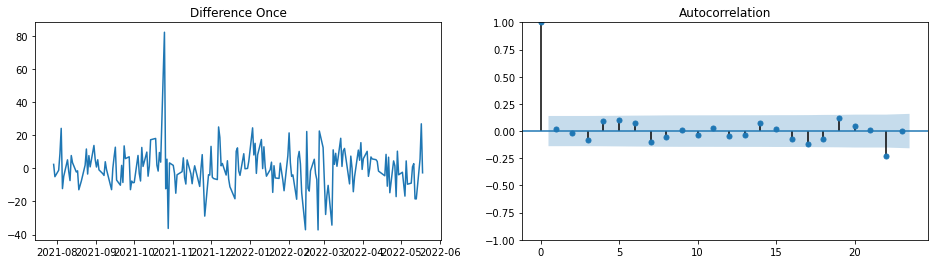

In [21]:
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

q=1,2,3,4 are all close values so we will decide by autu arima model

# AUTO-ARIMA

In [22]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [23]:
result = auto_arima(df2.Close, trace=True,supress_warnings=True)
print(result.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1575.398, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1574.810, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1576.756, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1576.754, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1572.826, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1578.749, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.938 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -785.413
Date:                Fri, 29 Jul 2022   AIC                           1572.826
Time:                        08:21:08   BIC                           1576.119
Sample:                             0   HQIC                          1574.159
          

In [24]:
best = auto_arima(df2.Close, trace=False,supress_warnings=True,return_valid_fits=False)


In [25]:
diff = df2.Close.diff().dropna()


In [26]:
best = auto_arima(diff, trace=False,supress_warnings=True,return_valid_fits=False)
t=(best.get_params().get("order")[0],best.get_params().get("order")[1],best.get_params().get("order")[2])
t

(0, 0, 0)

#Fitting Model & making Prediction

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
model = ARIMA(diff,order=t)
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  199
Model:                          ARIMA   Log Likelihood                -785.405
Date:                Fri, 29 Jul 2022   AIC                           1574.810
Time:                        08:21:10   BIC                           1581.396
Sample:                             0   HQIC                          1577.476
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1121      0.933      0.120      0.904      -1.716       1.940
sigma2       156.9061      7.034     22.307      0.000     143.120     170.692
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               710.79
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.02
Prob(H) (two-sided):                  0.81   Kurtosis:                        12.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Make Prediction On Test Set**

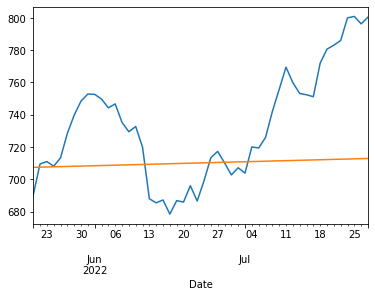

In [29]:
start1=len(diff)
end1 = len(diff) + len(test_data) -1

pred=model.predict(start=start1,end=end1,typ='levels').rename('ARIMA predictions')
pred.index=test_data.index
pred_cumsum=pred.cumsum()
final_preds=pred_cumsum + df2.Close[-1]
test_data["Close"].plot()
final_preds.plot()
# pred.plot(legend=True)
# test_data['Close'].plot(legend=True)


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [31]:
test_data=test_data["Close"]

In [32]:
mse = mean_squared_error(test_data, final_preds)
print("MSE: "+ str(mse))
mae = mean_absolute_error(test_data, final_preds)
print("MAE: "+ str(mae))
rmse = math.sqrt(mean_squared_error(test_data, final_preds))
print("RMSE: "+ str(rmse))
mape = np.mean(np.abs(final_preds-test_data) / np.abs(test_data))
print(f"MAPE: {mape}")


MSE: 1613.5354004170797
MAE: 31.62839162967529
RMSE: 40.168836184498545
MAPE: 0.041947656196460105
